## What is going on here?

* In this experiment we are trying to create a DNN which is going to classify images from CIFAR10
* We will use mlflow to track the performance of the DNN model
* MLFlow has experimental support for autolog in Pytorch Lightning, but not in vanilla one. We'll simply use regular methods.

## Load the dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


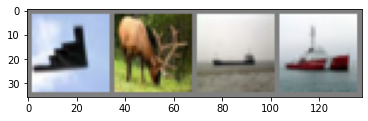

plane  deer  ship  ship


In [2]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [3]:
import os
import mlflow
remote_server_uri = "http://localhost:5000"
mlflow.set_tracking_uri(remote_server_uri)

if mlflow.get_experiment_by_name('exp3') is None:
    artifact_repo = f'file://{os.getcwd()}/mlflow'
    mlflow.create_experiment('exp3', artifact_location=artifact_repo)
mlflow.set_experiment('exp3')
mlflow.set_tag('framework', 'pytorch')
mlflow.set_tag('dataset', 'cifar10')

In [4]:
run = mlflow.active_run()
run.info

<RunInfo: artifact_uri='file:///home/koperek/Projects/mlflow/mlflow/a3f9ec93f99546dc920f43e165af9b32/artifacts', end_time=None, experiment_id='1', lifecycle_stage='active', run_id='a3f9ec93f99546dc920f43e165af9b32', run_uuid='a3f9ec93f99546dc920f43e165af9b32', start_time=1616277475343, status='RUNNING', user_id='koperek'>

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
mlflow.log_param("lr", 0.001)
mlflow.log_param("momentum", 0.9)
mlflow.set_tag("optimizer", "sgd")

In [7]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            mlflow.log_metric("training_loss", running_loss / 2000)
            running_loss = 0.0
            
    # we should use a separate validation dataset, just to demonstrate the metrics in mlflow
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        mlflow.log_metric('test_accuracy', test_accuracy)

print('Finished Training')

[1,  2000] loss: 2.174
[1,  4000] loss: 1.811
[1,  6000] loss: 1.653
[1,  8000] loss: 1.583
[1, 10000] loss: 1.493
[1, 12000] loss: 1.480
[2,  2000] loss: 1.406
[2,  4000] loss: 1.372
[2,  6000] loss: 1.340
[2,  8000] loss: 1.323
[2, 10000] loss: 1.311
[2, 12000] loss: 1.302
[3,  2000] loss: 1.222
[3,  4000] loss: 1.225
[3,  6000] loss: 1.207
[3,  8000] loss: 1.201
[3, 10000] loss: 1.189
[3, 12000] loss: 1.163
[4,  2000] loss: 1.089
[4,  4000] loss: 1.107
[4,  6000] loss: 1.108
[4,  8000] loss: 1.114
[4, 10000] loss: 1.115
[4, 12000] loss: 1.081
Finished Training


## Save the model (in torch and in mlflow)

In [23]:
import os

output_dir = 'cifar10_model'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

PATH = f'./{output_dir}/cifar_net.pth'
torch.save(net.state_dict(), PATH)

abspath = os.path.abspath(f'./{output_dir}/cifar10.mlflow')
mlflow.pytorch.save_model(net, path=abspath)

## Evaluating the model

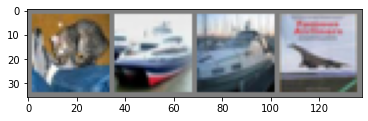

GroundTruth:    cat  ship  ship plane


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
outputs = net(images)

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
        
print('Accuracy of the network on the 10000 test images: %d %%' % (test_accuracy))

Accuracy of the network on the 10000 test images: 60 %


In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 74 %
Accuracy of  bird : 47 %
Accuracy of   cat : 33 %
Accuracy of  deer : 56 %
Accuracy of   dog : 38 %
Accuracy of  frog : 80 %
Accuracy of horse : 68 %
Accuracy of  ship : 80 %
Accuracy of truck : 65 %
